## Coleta de dados

In [65]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency

import warnings

In [55]:
def make_capital(x):
    try:
        return x.capitalize()
    except:
        return x    

df = pd.DataFrame()

df_year = {}

warnings.filterwarnings('ignore', category=UserWarning)

for year in range(2019, 2024):
    df_year[year] = pd.read_excel('dados.xlsx', str(year))
    
df = pd.concat([df_year[year] for year in range(2019, 2024)])
    
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)
df.dropna(subset='medEnv', inplace=True)
df['medEnv'] = df['medEnv'].apply(lambda x: make_capital(x)).apply(lambda x: x.replace(' ', ''))
df['AvalAdes'] = df['AvalAdes'].replace(np.nan, 'NA')

df['year'] = df['Date'].apply(lambda x: x.year)
df['month'] = df['Date'].apply(lambda x: x.month)

df.Age = np.where(df.Age > 6000, df.Age[df.Age < 6000].mean(), df.Age)

### 1. Quais são os medicamentos mais solicitados, ao longo do tempo?

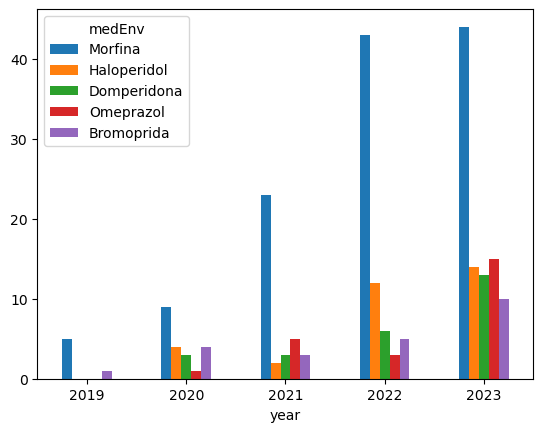

In [17]:
top_5 = df.groupby('medEnv').count().sort_values('Pac', ascending = False).head(5).index.to_list()
df_medenv_per_year = pd.pivot_table(df, values='Pac', index=['year'], aggfunc='count', columns='medEnv')[top_5].plot(use_index=True, kind='bar')#.sort_values(2023, ascending=False)

plt.xticks(rotation=0);

In [267]:
df.pivot_table(index='medEnv', columns='year', values='Pac', aggfunc='count').sort_values(2023, ascending=False).head(11).replace(np.nan, 0)

year,2019,2020,2021,2022,2023
medEnv,,,,,
Morfina,5.0,8.0,20.0,32.0,42.0
Haloperidol,0.0,4.0,1.0,9.0,13.0
Domperidona,0.0,3.0,3.0,5.0,13.0
Omeprazol,0.0,1.0,5.0,3.0,13.0
Dexametasona,0.0,0.0,2.0,7.0,13.0
Quetiapina,0.0,0.0,5.0,3.0,11.0
Ondansetrona,0.0,0.0,2.0,1.0,10.0
Dipirona,2.0,1.0,1.0,5.0,9.0
Bromoprida,1.0,4.0,2.0,5.0,9.0


 ### 2. Qual(is) é(são) as equipes mais acionadas, ao longo do tempo.

<Axes: ylabel='year'>

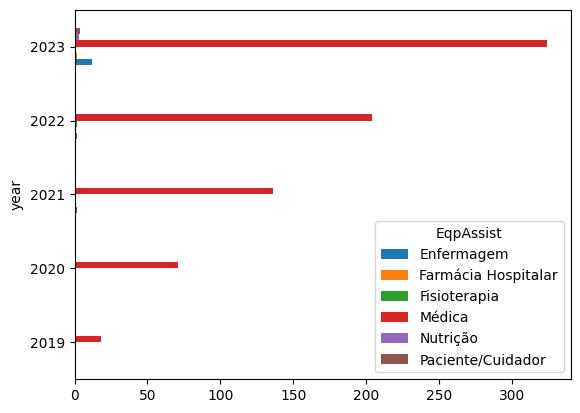

In [5]:
df_eqpassist_per_year = pd.pivot_table(df, values='Pac', index=['year'], aggfunc='count', columns='EqpAssist')#.plot(use_index=True)#.sort_values(2023, ascending=False)
df_eqpassist_per_year.plot(use_index=True, kind='barh')#.sort_values(2023, ascending=False)

In [269]:
df.pivot_table(index='EqpAssist', columns='year', values='Pac', aggfunc='count').sort_values(2023, ascending=False).replace(np.nan, 0)

year,2019,2020,2021,2022,2023
EqpAssist,,,,,
Médica,19.0,71.0,138.0,205.0,324.0
Enfermagem,0.0,0.0,2.0,2.0,12.0
Paciente/Cuidador,0.0,0.0,0.0,0.0,4.0
Nutrição,0.0,1.0,0.0,0.0,3.0
Farmácia Hospitalar,0.0,0.0,0.0,0.0,2.0
Fisioterapia,0.0,0.0,0.0,2.0,0.0


### 3. Correlação entre problema primário e secundário

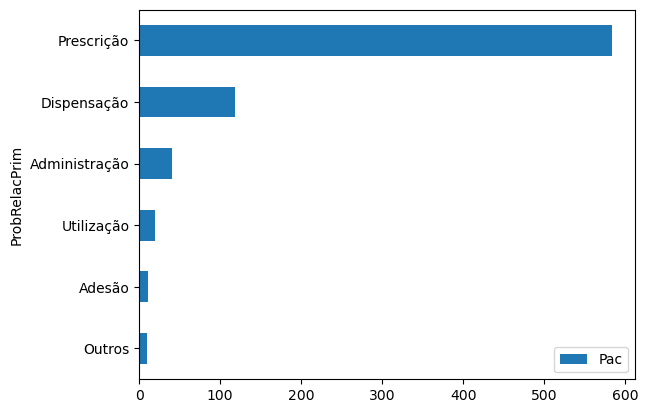

In [18]:
df.groupby('ProbRelacPrim').count()[['Pac']].sort_values('Pac').plot(kind='barh');

### 4. Correlação entre problema primário e estratégia primária

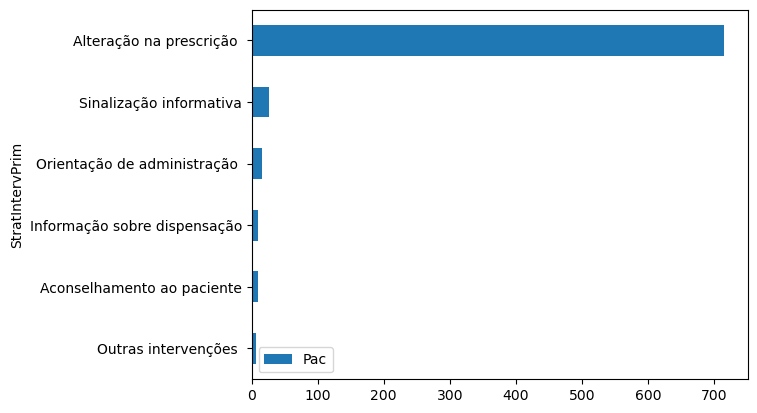

In [19]:
df.groupby('StratIntervPrim').count()[['Pac']].sort_values('Pac').plot(kind='barh');

In [21]:
crosstab_prp_sip = pd.crosstab(df.StratIntervPrim, df.ProbRelacPrim)
crosstab_prp_sip.transpose()

StratIntervPrim,Aconselhamento ao paciente,Alteração na prescrição,Informação sobre dispensação,Orientação de administração,Outras intervenções,Sinalização informativa
ProbRelacPrim,,,,,,
Adesão,3,6,2,0,0,0
Administração,0,24,1,8,4,4
Dispensação,0,109,6,1,2,0
Outros,0,3,0,0,0,7
Prescrição,3,568,0,5,0,7
Utilização,3,5,1,2,0,8


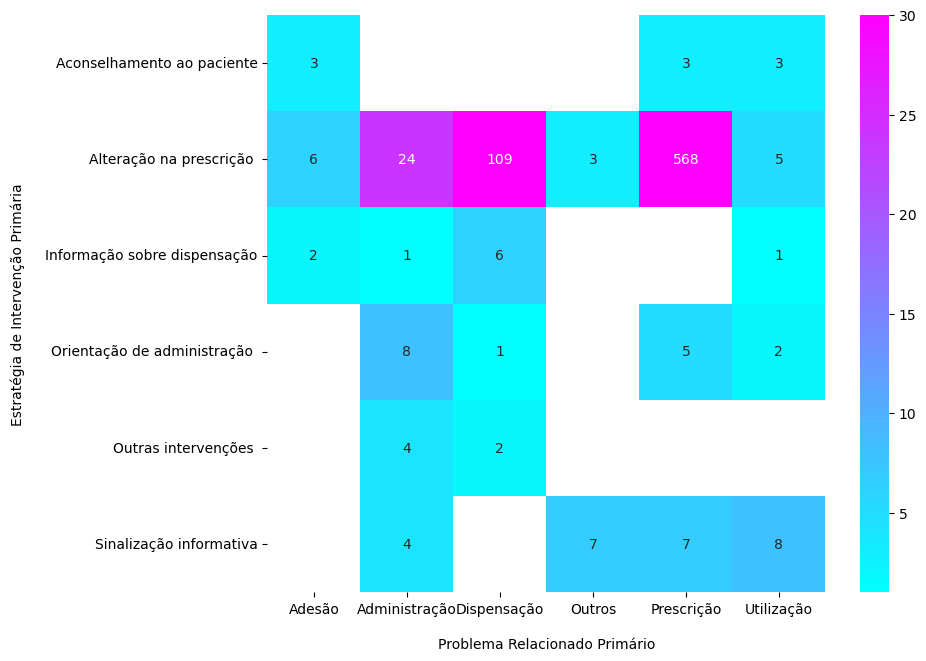

In [28]:
plt.figure(figsize=(9, 7.5))
ax = sns.heatmap(crosstab_prp_sip.replace(0, np.nan), cmap='cool', annot=True, fmt=".0f", vmax=30)
ax.set_ylabel('Estratégia de Intervenção Primária', labelpad=15)
ax.set_xlabel('Problema Relacionado Primário', fontsize=10, labelpad=15);

plt.xticks(rotation=0);

In [33]:
print('chi2 = ', chi2_contingency(crosstab_prp_sip)[0])
print('p = ', chi2_contingency(crosstab_prp_sip)[1])

chi2 =  533.9643431847177
p =  6.894204125940928e-97


### 5. Correlação entre problema primário e avaliação de adesão

In [34]:
df.groupby('AvalAdes').count()[['Pac']].sort_values('Pac')#.plot(kind='barh')

,Pac
AvalAdes,
NAJ,22
NA,57
A,703


In [35]:
crosstab_prp_aa = pd.crosstab(df.ProbRelacPrim, df.AvalAdes)
crosstab_prp_aa

AvalAdes,A,NA,NAJ
ProbRelacPrim,,,
Adesão,9,2,0
Administração,35,5,1
Dispensação,115,2,1
Outros,6,4,0
Prescrição,526,37,20
Utilização,12,7,0


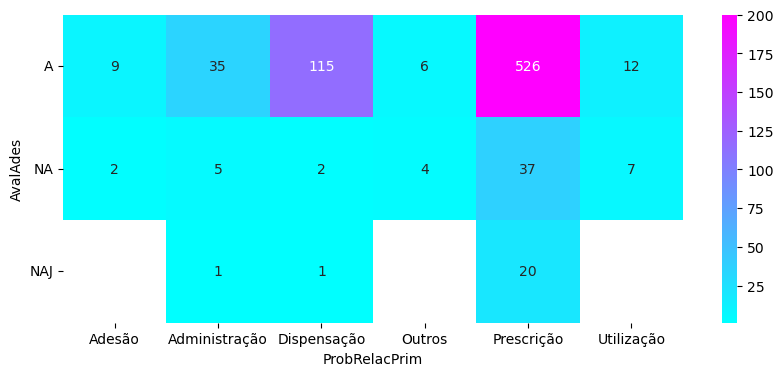

In [43]:
plt.figure(figsize=(10, 4))
sns.heatmap(crosstab_prp_aa.transpose().replace(0, np.nan), cmap='cool', annot=True, fmt=".0f", vmax=200)
#plt.xticks(rotation=25)
plt.yticks(rotation=0);

In [40]:
print('chi2 = ', chi2_contingency(crosstab_prp_aa)[0])
print('p = ', chi2_contingency(crosstab_prp_aa)[1])

chi2 =  53.35945700585004
p =  6.38460623012863e-08


In [310]:
print('chi2 = ', chi2_contingency(crosstab_prp_aa)[0])
print('p = ', chi2_contingency(crosstab_prp_aa)[1])

chi2 =  3.427749490700395
p =  0.6343471283048031


### 5.2. Correlação entre estratégia primária e avaliação de adesão

In [44]:
crosstab_sip_aa = pd.crosstab(df.AvalAdes, df.StratIntervPrim)
crosstab_sip_aa

StratIntervPrim,Aconselhamento ao paciente,Alteração na prescrição,Informação sobre dispensação,Orientação de administração,Outras intervenções,Sinalização informativa
AvalAdes,,,,,,
A,8,650,9,14,6,16
NA,1,43,1,2,0,10
NAJ,0,22,0,0,0,0


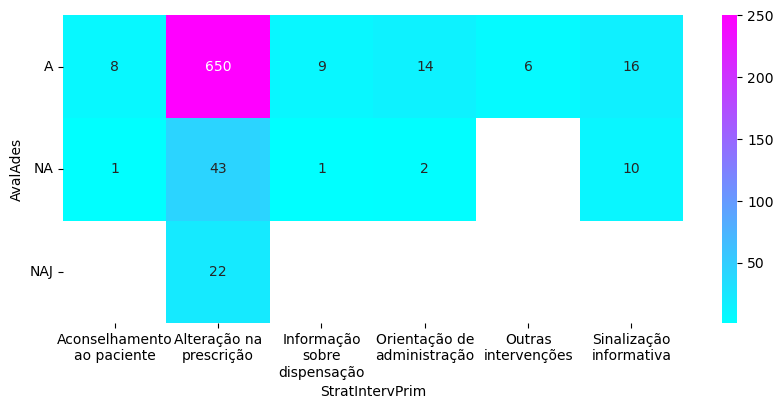

In [46]:
import textwrap

# Create a heatmap
plt.figure(figsize=(10, 4))
ax = sns.heatmap(crosstab_sip_aa.replace(0, np.nan), cmap='cool', annot=True, fmt=".0f", vmax=250)

# Wrap the x-tick labels without cutting words
wrapper = textwrap.TextWrapper(width=15, break_long_words=False)
wrapped_labels = [wrapper.fill(label) for label in crosstab_sip_aa.columns]

# Set the wrapped x-tick labels at their positions and center them
ax.set_xticks([i + 0.5 for i in range(len(crosstab_sip_aa.columns))])
ax.set_xticklabels(wrapped_labels, rotation=0, fontsize=10, ha='center')


# Set y-tick labels
plt.yticks(rotation=0, fontsize=10)

# Show the plot
plt.show()

In [48]:
print('chi2 = ', chi2_contingency(crosstab_sip_aa)[0])
print('p = ', chi2_contingency(crosstab_sip_aa)[1])

chi2 =  42.119245340297965
p =  7.141033261871006e-06


### 6. Correlação entre estratégia primária e estratégia secundária

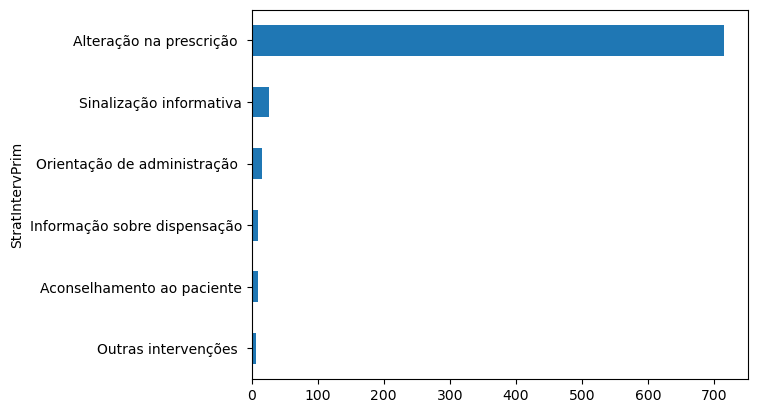

In [52]:
df.groupby('StratIntervPrim').count()[['Pac']].sort_values('Pac').plot(kind='barh', legend=False);

In [53]:
len(np.unique(df.groupby(['StratIntervSec']).count()[['Pac']].sort_values('Pac').index.to_list()))#.head(5).plot(kind='barh')

28

### 7. Distribuição de Idade dos Pacientes

In [79]:
df[['Age']].describe().drop('count')

,Age
mean,68.265385
std,16.460252
min,17.000000
25%,57.000000
50%,68.132692
75%,82.000000
max,103.000000


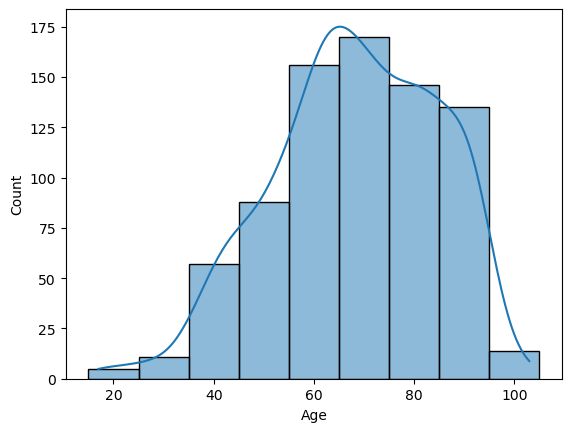

In [63]:
sns.histplot(df.Age, kde=True, bins=10, binwidth=10, binrange=(15, 105));

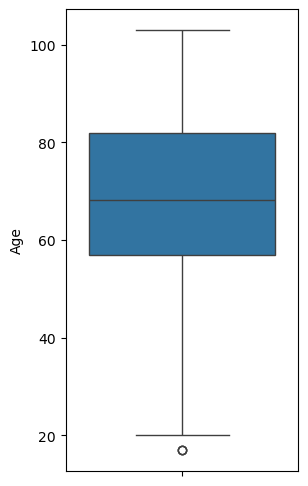

In [64]:
plt.figure(figsize=(3, 6))
sns.boxplot(df.Age);

In [66]:
df.pivot_table(index='medEnv', values='Age', aggfunc='mean')

,Age
medEnv,
Abiraterona,91.000000
Acetilcisteína,60.500000
Aguaparainjetáveis,90.000000
Albendazol,82.000000
Alopurinol,78.000000
...,...
Zolpidem,74.333333
Ácidotranexâmico,63.666667
Ácidozoledrônico,78.000000


In [26]:
df.pivot_table(index='medEnv', values='Age', aggfunc='mean')

,Age
medEnv,
Abiraterona,91.000000
Acetilcisteína,60.500000
Agua para injetáveis,90.000000
Albendazol,82.000000
Alopurinol,78.000000
...,...
Zolpidem,74.333333
Ácido tranexâmico,63.666667
Ácido zoledrônico,78.000000


In [67]:
age_groups = [df[['Age']][df['medEnv'] == group] for group in df['medEnv'].unique() if df['medEnv'][df['medEnv'] == group].count() >= 2]

f_statistic, p_value = stats.f_oneway(*age_groups)
f_statistic, p_value

(array([2.09019184]), array([4.26948089e-07]))

In [68]:
df['medEnv'].unique()

array(['Ácidozoledrônico', 'Bromoprida', 'Dipirona', 'Fenitoína',
       'Hidrocortisona', 'Lactulose', 'Metadona', 'Morfina',
       'Paracetamol', 'Piperacilina+tazobactam', 'Vancomicina',
       'Amitriptilina', 'Anlodipino', 'Atropina', 'Bisacodil',
       'Budesonida', 'Ceftriaxona', 'Clonazepam', 'Cloretodesódio0,9%',
       'Cloretodesódio20%', 'Clorpromazina', 'Dimenidrato', 'Domperidona',
       'Fentanil', 'Fentanila', 'Fluconazol', 'Gabapentina', 'Glicose50%',
       'Haloperidol', 'Ibuprofeno', 'Ipratropio', 'Itraconazol',
       'Levomepromazina', 'Levotiroxina', 'Loperamida', 'Loratadina',
       'Metoclopramida', 'Metoprolol', 'Metronidazol', 'Midazolam',
       'Nortriptilina', 'Omeprazol', 'Propatilnitrato',
       'Valproatodesódio', 'Zolpidem', 'Aguaparainjetáveis',
       'Amoxicilina', 'Ampicilina+sulbactam', 'Budesonida+formoterol',
       'Carbamazepina', 'Carvedilol', 'Citalopram', 'Clindamicina',
       'Cloretodepotássio', 'Codeina+paracetamol', 'Dexametasona'

In [69]:
df_dropped = df[df.medEnv.apply(lambda x: x == x)]

grouped_data = [(df_dropped[df_dropped['medEnv'] == group]['Age'].values) for group in df_dropped['medEnv'].unique()]
#grouped_data
F_statistic, p_value = stats.f_oneway(*grouped_data)
p_value

1.6187243079822976e-05

In [226]:
df_dropped = df[df.medEnv.apply(lambda x: x == x)]

grouped_data = [(df_dropped[df_dropped['medEnv'] == group]['Age'].values) for group in df_dropped['medEnv'].unique()]
#grouped_data
F_statistic, p_value = stats.f_oneway(*grouped_data)
p_value

1.3594150014968015e-07

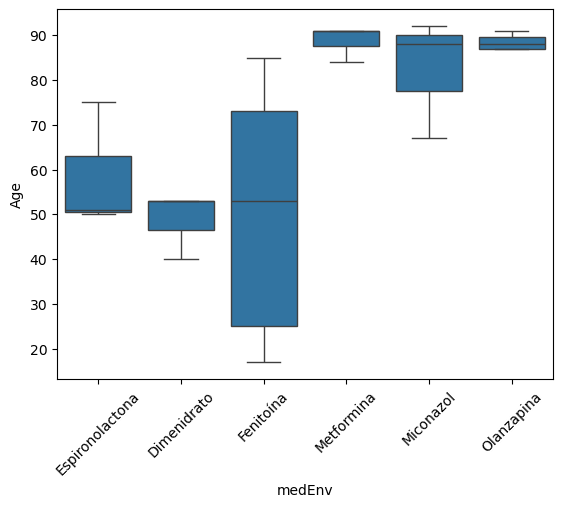

In [124]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_gby_me = df.pivot_table(index='medEnv', values='Age', aggfunc=['median', 'count'])

bot_5 = df_gby_me[df_gby_me[('count', 'Age')] >= 3].sort_values(('median', 'Age')).head(3).index.to_list()
top_5 = df_gby_me[df_gby_me[('count', 'Age')] >= 3].sort_values(('median', 'Age'), ascending=False).head(3).index.to_list()

sns.boxplot(data=df[df['medEnv'].isin(bot_5 + top_5)], x='medEnv', y='Age', order=bot_5 + top_5)
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

### Idade por grupo

In [ ]:
df.pivot_table(index='UniClin', values='Age', aggfunc='mean')

In [75]:
df.pivot_table(index='UniClin', values='Age', aggfunc='mean')

,Age
UniClin,
A,64.182125
C,81.076882


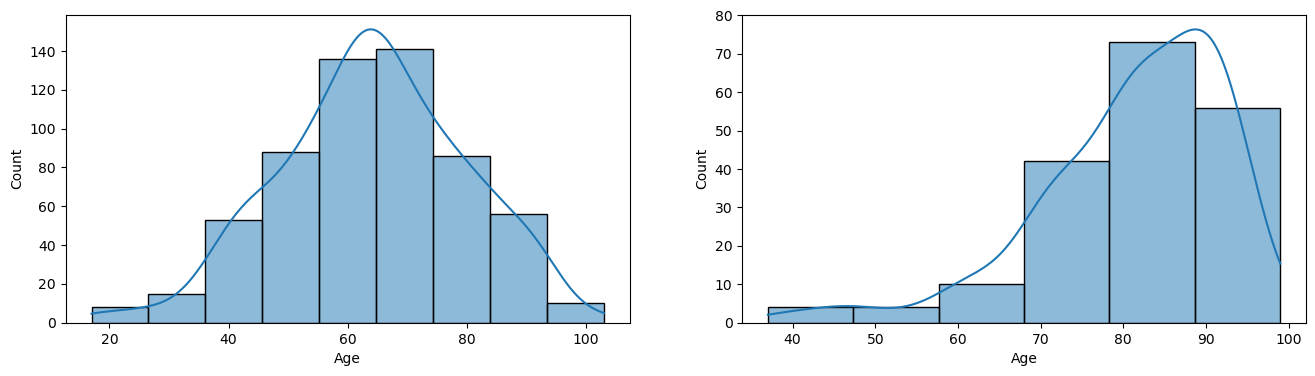

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(df[df['UniClin'] == 'A']['Age'], kde=True, binwidth=10, ax=ax[0]);

sns.histplot(df[df['UniClin'] == 'C']['Age'], kde=True, binwidth=10);


<Axes: xlabel='UniClin', ylabel='Age'>

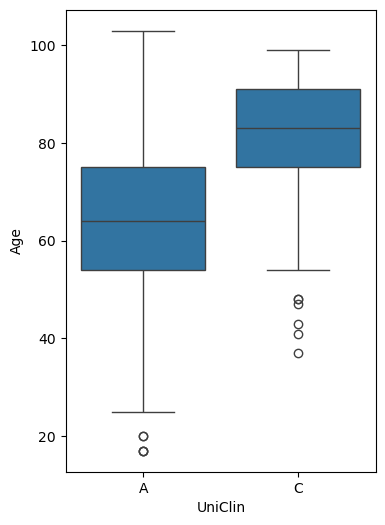

In [111]:
plt.figure(figsize=(4, 6))
sns.boxplot(df, x='UniClin', y='Age')

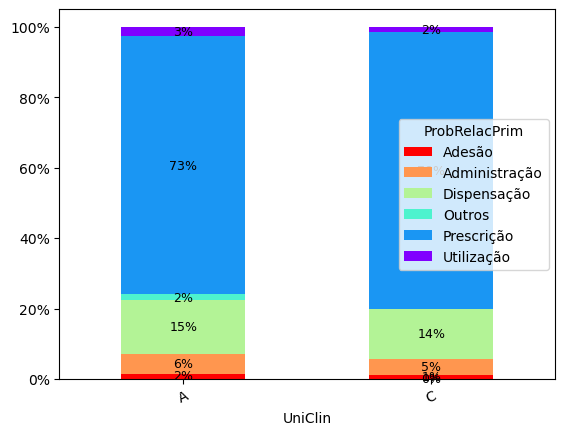

In [104]:
ax = pd.crosstab(df.UniClin, df.ProbRelacPrim, normalize='index')\
    .plot(kind='bar', stacked=True, colormap='rainbow_r')

#df.pivot_table(index='UniClin', columns='ProbRelacPrim', values='Pac', aggfunc='count')\
#    .plot(kind='bar', stacked=True, colormap='plasma')

for container in ax.containers:
    ax.bar_label(container, label_type='center', fmt='{:.0%}', fontsize=9, color='black')
    
plt.xticks(rotation=25)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))


<Figure size 20000x3000 with 0 Axes>

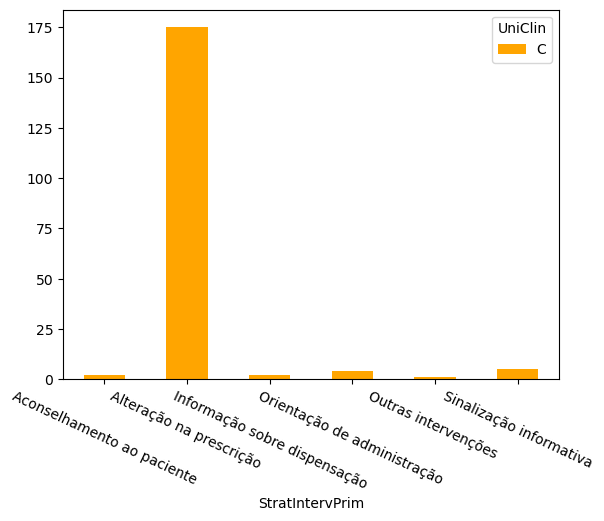

In [112]:
plt.figure(figsize=(200, 30))

df.pivot_table(index='StratIntervPrim', columns='UniClin', values='Pac', aggfunc='count')[['C']]\
    .plot(kind='bar', stacked=True, color='orange')

plt.xticks(rotation=-25);

<Axes: ylabel='medEnv'>

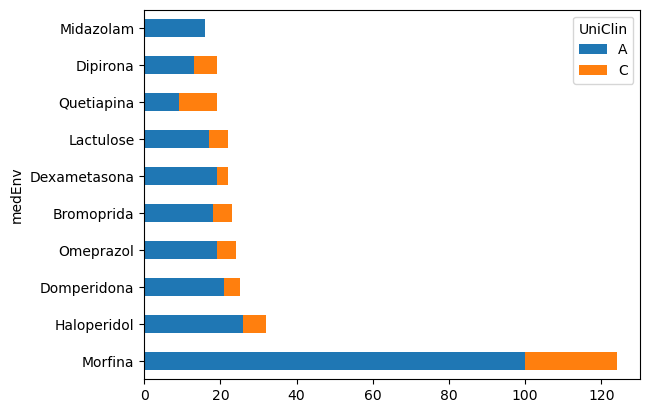

In [132]:
df_dropped = df[df.medEnv.apply(lambda x: x == x)]

#grouped_data = [(df_dropped[df_dropped['medEnv'] == group]['Age'].values) for group in df_dropped['medEnv'].unique()]
#grouped_data
#F_statistic, p_value = stats.f_oneway(*grouped_data)
#p_value

df_med = df.pivot_table(index='medEnv', columns='UniClin', values='Pac', aggfunc='count', margins='index')\
    .sort_values('All', ascending=False)

df_med[['A', 'C']].head(11).tail(10).plot(kind='barh', stacked=True)

### IFs Aceitas


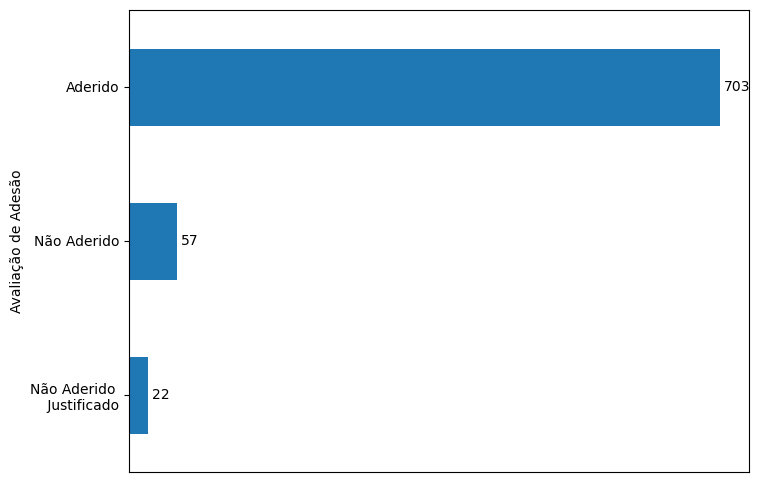

In [116]:
#

ax = df.pivot_table(values='Pac', index='AvalAdes', aggfunc='count').sort_values('Pac').plot(kind='barh', figsize=(8, 6), legend=False)

# Annotating the bars
for bar in ax.patches:
    ax.annotate(
        f'{int(bar.get_width())}',  # Label text (converts bar width to integer)
        (bar.get_width()+ 5, bar.get_y() + bar.get_height() / 2),  # Position (x, y)
        ha='left', va='center', fontsize=10  # Alignment and font size
    )

ax.set_xticks([])


ax.set_xticks([])  # Remove x-ticks
plt.ylabel('Avaliação de Adesão')

# Custom y-ticks
plt.yticks(
    range(len(ax.get_yticklabels())),  # Numeric positions
    ['Aderido', 'Não Aderido', 'Não Aderido \n Justificado'][::-1]  # Custom labels
);


### Pivot Table


In [117]:
freqreldict = {}
for ProbRelacPrim in np.unique(df.ProbRelacPrim.to_list()):

    freqrel = 1/df[df['ProbRelacPrim'] == ProbRelacPrim].Pac.count()
    freqreldict[str(ProbRelacPrim)] = freqrel

freqreldict

df['FreqRel'] = df.ProbRelacPrim.map(freqreldict)

true_pivot = df.pivot_table(index=['ProbRelacPrim', 'ProbRelacSec'], values=['FreqRel', 'Pac'], aggfunc={'FreqRel': 'sum', 'Pac': 'count'})[['Pac', 'FreqRel']]

aval_pivot = df.pivot_table(index=['ProbRelacPrim', 'ProbRelacSec'], columns='AvalAdes', values='Pac', aggfunc='count')
aval_pivot.replace(np.nan, 0, inplace=True)
aval_pivot['AdesRate'] = (aval_pivot['A'])/(aval_pivot['A'] + aval_pivot['NAJ']+ aval_pivot['NA'])

true_pivot = true_pivot.join(aval_pivot).drop(columns=['A', 'NA', 'NAJ'])#, inplace=True)

sub_pivot = df.pivot_table(index='ProbRelacPrim', values=['FreqRel', 'Pac'], aggfunc={'FreqRel': 'sum', 'Pac': 'count'})[['Pac', 'FreqRel']]

sub_aval_pivot = df.pivot_table(index=['ProbRelacPrim'], columns='AvalAdes', values='Pac', aggfunc='count')
sub_aval_pivot.replace(np.nan, 0, inplace=True)
sub_aval_pivot['AdesRate'] = (sub_aval_pivot['A'])/(sub_aval_pivot['A'] + sub_aval_pivot['NAJ']+ sub_aval_pivot['NA'])

sub_pivot = sub_pivot.join(sub_aval_pivot, on=['ProbRelacPrim']).drop(columns=['A', 'NA', 'NAJ'])

sub_pivot['ProbRelacSec'] = ''
sub_pivot.reset_index(inplace=True)
sub_pivot.set_index(['ProbRelacPrim', 'ProbRelacSec'], inplace=True)

final_pivot = pd.concat([true_pivot, sub_pivot]).sort_values(['ProbRelacPrim', 'ProbRelacSec'])
final_pivot.rename(columns={'Pac': 'Frequência Absoluta', 'FreqRel': 'Frequência Relativa', 'AdesRate': 'Taxa de Adesão'}, inplace=True)

In [118]:
final_pivot

Frequência Absoluta  \
ProbRelacPrim ProbRelacSec                                                              
Adesão                                                                             11   
               Automedicação indevida pelo paciente                                 4   
               Descontinuação indevida do medicamento pelo pa...                    1   
               Falta de adesão ao tratamento pelo paciente                          4   
               Problema de acesso à medicação                                       2   
Administração                                                                      41   
               Conservação/preparo inadequado (diluente/estab...                    2   
               Dose/concentração inadequada                                         4   
               Horário/frequência inadequada                                        3   
               Incompatibilidade medicamentosa contraindicada                       5   
               Omissão de doses (subdosagem)                                        6   
               Outros problemas de administração                                    9   
               Via inadequada                                                       9   
              Medicamento inapropriado ou contraindicado                            3   
Dispensação                                                                       118   
               Dose/quantidade incorreta                                            2   
               Falta no estoque                                                   103   
               Forma farmacêutica incorreta                                         2   
               Medicamento incorreto                                                1   
               Outros problemas de dispensação                                      8   
               Outros problemas de prescrição                                       2   
Outros                                                                             10   
               (descrever na coluna "Observações")                                  5   
               Disponibilidade de alternativa medicamentosa m...                    1   
               Prescrito medicamento não-padronizado                                2   
               Reação adversa importante                                            2   
Prescrição                                                                        583   
               Disponibilidade de alternativa medicamentosa m...                    8   
               Dose abaixo das recomendações (subdose)                             48   
               Dose acima das recomendação (sobredose)                             50   
               Duração do tratamento prescrita inadequada                          14   
               Falta no estoque                                                     4   
               Forma farmacêutica ou via de administração pre...                   96   
               Frequência ou horários de administração prescr...                   24   
               Medicamento sem indicação clínica definida                          13   
               Omissão de doses (subdosagem)                                        1   
               Outros problemas de prescrição                                     139   
               Outros problemas de utilização                                       1   
               Possível incompatibilidade medicamentosa contr...                    2   
               Possível interação medicamento-alimento import...                    3   
               Possível interação medicamento-medicamento con...                   16   
               Possível interação medicamento-medicamento grave                     1   
               Prescrito medicamento não-padronizado                               21   
               Via inadequada                                

In [119]:
final_pivot.to_excel('pivot.xlsx')

### Gráfico de Adesão

In [121]:
df_years = df.pivot_table(index='year', columns='AvalAdes', values='Pac', aggfunc='count')
df_years.replace(np.nan, 0, inplace=True)

df_years['Total'] = df_years['A'] + df_years['NA'] + df_years['NAJ']
df_years['AdesRate'] = df_years['A']/df_years['Total']*100

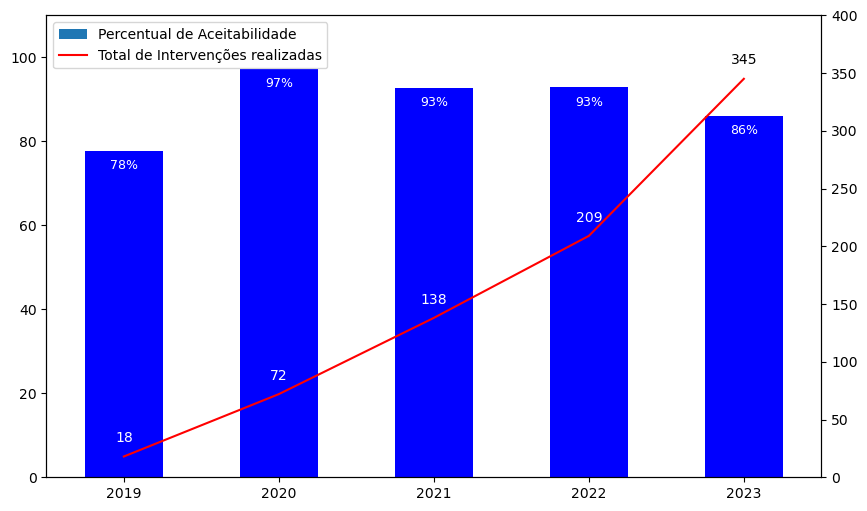

In [123]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

df_years.plot(y='AdesRate', kind='bar', legend=False, ax=ax1, color='blue')

plt.xticks(rotation=0)
plt.xlabel('')

for i, value in enumerate(df_years['AdesRate']):
    ax1.text(i, value - 5, f'{str(round(value))}%', ha='center', va='bottom', fontsize=9, color='white')

ax2 = ax1.twinx()

df_years.reset_index().plot(y='Total', kind='line', color='red', ax=ax2, legend=False)

for i, value in enumerate(df_years.reset_index()['Total']):
    ax2.text(i, value + 10, str(round(value)), ha='center', va='bottom', fontsize=10, color='white')

ax2.text(i, value + 10, str(round(value)), ha='center', va='bottom', fontsize=10, color='black')

ax1.set_ylim(0, 110)  # Adjust for AdesRate
ax2.set_ylim(0, 400)  # Adjust for Total

ax1.set_xlim(-0.5, len(df_years) - 0.5)  # Dynamically adjust based on data length

bar_legend = ax1.bar([], [], color='blue', label='Percentual de Aceitabilidade')
line_legend, = ax2.plot([], [], color='red', label='Total de Intervenções realizadas')

ax1.legend(handles=[bar_legend, line_legend], loc='upper left', fontsize=10);